# This notebook explores the effect of using optimization routine and data extrapolation to zero for S(Q)

We are going to load a data spectrum and background Spectrum of $Mg_2SiO_4$. The data is not optimal since it was not corrected for self absorption or oblique x-ray incidence on the detector. A way to try to correct for this artifially is using an optimization method described in Eggert et al. (2002). This is very useful for the data analysis of total scattering experiments from a sample loaded in a diamond anvil cell were the background might change with compression and therefore almost never is perfect.

In [1]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt

sys.path.insert(1, os.path.join(os.getcwd(), '../../'))
from glassure.core.calc import calculate_fr, calculate_sq, optimize_sq, calculate_gr
from glassure.core.utility import extrapolate_to_zero_poly, convert_density_to_atoms_per_cubic_angstrom
from glassure.core import Spectrum
import numpy as np

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##1. Effect on S(Q)

We are going to compare three different S(Q) pattern: 
  - "raw": pattern which is just the collected diffraction data subtracted by its background
  - "opt": pattern optimized for an $r_{cutoff}$ of 1.5 and using 10 iterations
  - "extr_opt": raw pattern which was extrapolated to zero using a polynomial function and then optimized by the same parameters as "opt"

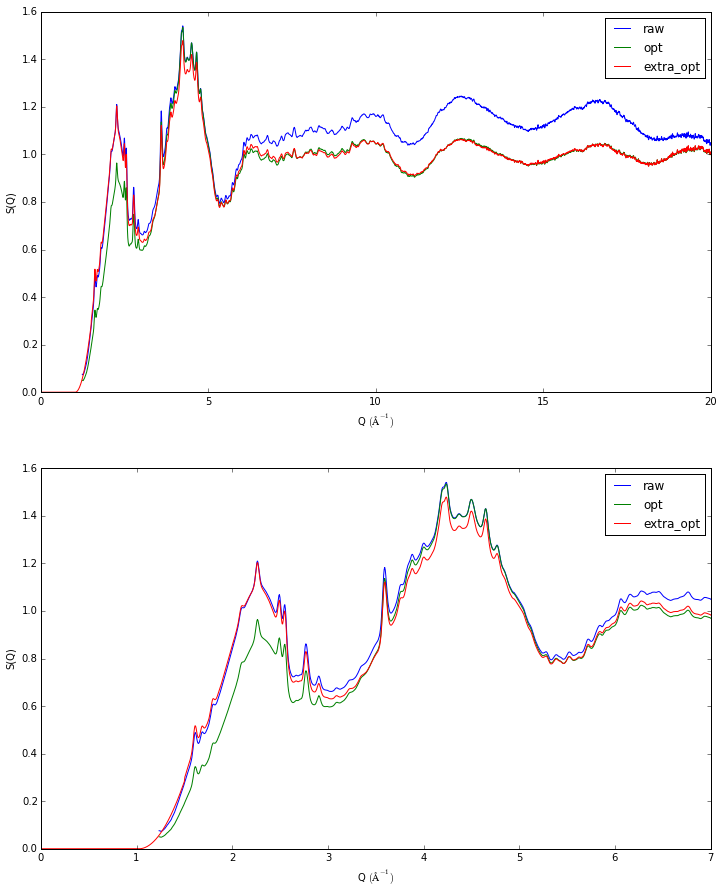

In [2]:
data_spectrum = Spectrum.from_file('../tests/data/Mg2SiO4_ambient.xy')
bkg_spectrum = Spectrum.from_file('../tests/data/Mg2SiO4_ambient_bkg.xy')
sample_spectrum = data_spectrum - bkg_spectrum

composition = {'Mg': 2, 'Si':1, 'O':4}
density = 2.9
atomic_density = convert_density_to_atoms_per_cubic_angstrom(composition, density)

sq = calculate_sq(sample_spectrum.limit(0,20), density, composition)
sq_opt = optimize_sq(sq, 1.4, 10, atomic_density)
sq_extr= extrapolate_to_zero_poly(sq, 1.5, replace=True)
sq_extr_opt = optimize_sq(sq_extr, 1.4, 10, atomic_density)

plt.figure(figsize=(12, 15))
plt.subplot(2,1,1)
plt.plot(*sq.data, label='raw')
plt.plot(*sq_opt.data, label='opt')
plt.plot(*sq_extr_opt.data, label='extra_opt')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(*sq.data, label='raw')
plt.plot(*sq_opt.data, label='opt')
plt.plot(*sq_extr_opt.data, label='extra_opt')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')
plt.xlim(0, 7)

plt.legend(loc='best')


The two plots clearly show that the optimization on a not extrapolated S(Q) results in an artificial lower intensity of the first sharp diffraction peak. Pointing to that extrapolation is needed for a sensible data analysis.

##2. Effect on F(r) and g(r)

In this section we going to compare F(r) and g(r) for 4 different data analysis methods:

  - "raw": using S(Q) from the original data without any modification
  - "raw_extr": using "raw" S(Q) which was extrapolated to zero Q using a polynomial function
  - "opt": using S(Q) optimized for an $r_{cutoff}$ of 1.5 and using 10 iterations
  - "extr_opt": using "opt" S(Q) which additionally was extrapolated to zero Q using a polynomial function and then optimized by the same parameters as "opt"



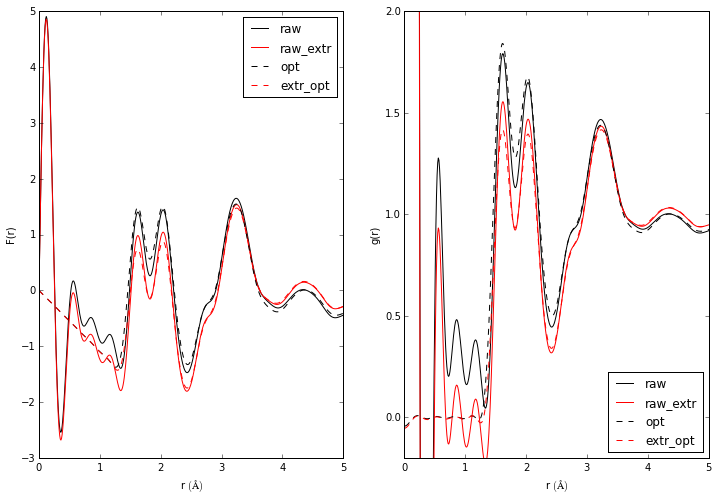

In [3]:
fr = calculate_fr(sq, use_modification_fcn=True)
fr_extr = calculate_fr(sq_extr, use_modification_fcn=True)
fr_opt = calculate_fr(sq_opt, use_modification_fcn=True)
fr_extr_opt = calculate_fr(sq_extr_opt, use_modification_fcn=True)

gr = calculate_gr(fr, density, composition)
gr_extr = calculate_gr(fr_extr, density, composition)
gr_opt = calculate_gr(fr_opt, density, composition)
gr_extr_opt = calculate_gr(fr_extr_opt, density, composition)

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(*fr.data, label='raw', color='k', ls='-')
plt.plot(*fr_extr.data, label='raw_extr',  color='r', ls='-')
plt.plot(*fr_opt.data, label='opt', color='k', ls='--')
plt.plot(*fr_extr_opt.data, label='extr_opt', color='r', ls='--')
plt.xlim(0,5)
plt.legend(loc='best')
plt.xlabel('r $(\AA)$')
plt.ylabel('F(r)')
plt.subplot(1, 2, 2)
plt.plot(*gr.data, label='raw', color='k', ls='-')
plt.plot(*gr_extr.data, label='raw_extr',  color='r', ls='-')
plt.plot(*gr_opt.data, label='opt', color='k', ls='--')
plt.plot(*gr_extr_opt.data, label='extr_opt', color='r', ls='--')
plt.ylim(-0.2, 2)
plt.xlim(0, 5)
plt.legend(loc='best')
plt.xlabel('r $(\AA)$')
plt.ylabel('g(r)')


The two plots show that the intensity of the first peaks strongly depend on whether the S(Q) was extrapolated or not. This has a huge effect on the resulting coordination numbers. Another important fact is that the "raw_extr" is below an r value of 1.4 very close to the optimized transformed data, however the non extrapolated "raw" data has a huge offset, which is further indicating that one should use extrapolation of the S(Q) to zero in order to get meaningful results. 